In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [21]:
import xgboost as xgb

 - __Import data, drop extra information and check count of target in class attribute__

In [12]:
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/Classification/Skyserver_SQL2_27_2018%206_51_39%20PM.csv"
dataset = pd.read_csv(url, error_bad_lines=False, header=0)
dataset.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
dataset.shape
dataset.info()
dataset["class"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ra        10000 non-null  float64
 1   dec       10000 non-null  float64
 2   u         10000 non-null  float64
 3   g         10000 non-null  float64
 4   r         10000 non-null  float64
 5   i         10000 non-null  float64
 6   z         10000 non-null  float64
 7   class     10000 non-null  object 
 8   redshift  10000 non-null  float64
 9   plate     10000 non-null  int64  
 10  mjd       10000 non-null  int64  
 11  fiberid   10000 non-null  int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 937.6+ KB


GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

 - __Create X and y datasets having independent vars and target var respectively__
 - __Apply Min max scaler on independent vars__
 - __Create 70:30 split for training and testing datasets__

In [18]:
X = dataset.drop(["class"], axis=1)
y = dataset["class"]

sc = MinMaxScaler()
X_scaled = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000, 11), (3000, 11), (7000,), (3000,))

# Random Search

 - __Instantiate a xgb classifier with softmax objective__
 - __This is because we have a target having more than 2 outcomes__

In [28]:
estimator = xgb.XGBClassifier(objective="multi:softmax", num_class=3, random_state=1)

 - __Declare a decimal range of learning rates__
 - __Declare a range of tree counts__
 - __Declare a set of max depth values__
 - __Declare a set of minimum child weight__
 - __Declare a set of sample proportions to be used in attribute sampling__
 - __Create dictionary which is a must for Random Search function__

In [29]:
learning_rate = np.arange(0.01,1,0.05)
n_estimators = np.arange(100, 500, 50)
max_depth = [2, 5, 10, 20, 30, 40, 50]
min_child_weight = [1,3,6]
colsample_bytree = [0.1, 0.5, 0.8, 1]

param_grid = {'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'colsample_bytree': colsample_bytree}

 - __Instantiate the RandomizedSearchCV object with accuracy as scoring metric__
 - __Push the parameter dictionary inside the object__

In [31]:
randomized_accuracy_fit = RandomizedSearchCV(estimator=estimator,
                                            param_distributions=param_grid,
                                            n_iter=50,
                                            scoring="accuracy",
                                            n_jobs=-1,
                                            refit=True,
                                            random_state=123,
                                            return_train_score=True,
                                            verbose=1,
                                            cv=StratifiedKFold(10)
                                            )

 - __Fit the RandomizedSearchCV object on X_train & y_train__

In [32]:
randomized_accuracy_fit.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 27.8min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           mi...
                   param_distributions={'colsample_bytree': [0.1, 0.5, 0.8, 1],
                                        'learning_rate': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0

 - __Print the best score found by RandomizedSearchCV__
 - __Print the best model found by RandomizedSearchCV__

In [33]:
print(randomized_accuracy_fit.best_score_)
print(randomized_accuracy_fit.best_estimator_)

0.991
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.46, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)


 - __Store the best model in an object__
 - __Create predictions from the best model__

In [34]:
best_estimator = randomized_accuracy_fit.best_estimator_
y_pred = best_estimator.predict(X_test)

 - __Calculate Accuracy and Recall Scores__
 - __Print the respective values__
 - __Create confusion matrix and print it using heatmap__

The accuracy score for the model is: 0.99
The recall score for the model is: 0.977


Text(91.68, 0.5, 'Actual')

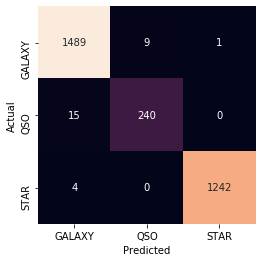

In [42]:
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred, average="macro"), 3)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False, xticklabels=['GALAXY', 'QSO', 'STAR'], yticklabels=['GALAXY', 'QSO', 'STAR'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Bayesian Search

In [53]:
from bayes_opt import BayesianOptimization

 - __Create lower and upper bounds of hyper parameters to be searched for__

In [55]:
pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,20),
    'childweight': (1, 6),
    'colsample': (0.1, 1.0),
    'gamma': (0, 5)}

 - __Declare a function which would use the hyper-paramter bounds in a xgb classifier__
 - __Compute mean accuracy of cross folds__

In [60]:
def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        childweight,
                        colsample,
                        gamma):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    clf = xgb.XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        colsample_bytree=colsample,
        min_child_weight=childweight,
        gamma=gamma)
    return np.mean(cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(10), scoring='accuracy'))

 - __Instantiate the BayesianOptimization object__
 - __First arguement is the function that declares a xgb classifier with certain set of hyper parameters__
 - __Second arguement is the set of hyper parameter bounds__

In [61]:
optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1)

 - __Create 100 bayesian steps of optimization and 8 steps of random exploration__

In [62]:
optimizer.maximize(n_iter=100, init_points=8, acq='ei')

|   iter    |  target   | childw... | colsample |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------------------------------
|  1        |  0.9901   |  3.085    |  0.7483   |  0.000571 |  0.3093   |  5.495    |  183.1    |
|  2        |  0.99     |  1.931    |  0.411    |  1.984    |  0.5434   |  10.13    |  716.7    |
|  3        |  0.9909   |  2.022    |  0.8903   |  0.1369   |  0.6738   |  10.09    |  602.8    |
|  4        |  0.9894   |  1.702    |  0.2783   |  4.004    |  0.9686   |  8.328    |  723.1    |
|  5        |  0.99     |  5.382    |  0.9051   |  0.4252   |  0.04866  |  5.887    |  890.3    |
|  6        |  0.9893   |  1.492    |  0.479    |  4.789    |  0.5378   |  14.76    |  384.0    |
|  7        |  0.9897   |  4.433    |  0.8512   |  0.09144  |  0.7526   |  19.81    |  773.3    |
|  8        |  0.9904   |  2.402    |  0.8104   |  0.5161   |  0.4534   |  18.45    |  364.3    |
|  9        |  0.989

|  51       |  0.9887   |  5.567    |  0.3746   |  4.755    |  0.7435   |  3.092    |  989.6    |
|  52       |  0.9893   |  5.871    |  0.1137   |  0.6427   |  0.931    |  3.056    |  106.6    |
|  53       |  0.989    |  4.562    |  0.4366   |  1.244    |  0.3326   |  19.64    |  991.3    |
|  54       |  0.9893   |  4.717    |  0.5779   |  3.76     |  0.2224   |  19.9     |  102.8    |
|  55       |  0.9893   |  5.689    |  0.9579   |  3.596    |  0.9672   |  3.539    |  998.8    |
|  56       |  0.9897   |  5.555    |  0.6261   |  3.246    |  0.8636   |  19.93    |  102.1    |
|  57       |  0.989    |  3.614    |  0.3982   |  4.507    |  0.8823   |  3.01     |  110.2    |
|  58       |  0.9903   |  1.461    |  0.3807   |  0.8085   |  0.01768  |  3.173    |  996.5    |
|  59       |  0.9884   |  1.913    |  0.1125   |  0.2795   |  0.3314   |  19.79    |  994.7    |
|  60       |  0.9907   |  1.075    |  0.6709   |  1.289    |  0.7876   |  3.209    |  107.4    |
|  61       |  0.990

|  102      |  0.9894   |  3.89     |  0.7787   |  4.174    |  0.865    |  3.108    |  986.8    |
|  103      |  0.9899   |  5.153    |  0.2458   |  1.411    |  0.8277   |  17.13    |  127.6    |
|  104      |  0.9913   |  1.354    |  0.4172   |  0.9366   |  0.3987   |  3.044    |  969.6    |
|  105      |  0.991    |  1.579    |  0.7049   |  0.05145  |  0.235    |  3.128    |  531.4    |
|  106      |  0.9909   |  1.194    |  0.8437   |  0.08758  |  0.8646   |  4.566    |  543.4    |
|  107      |  0.9906   |  1.174    |  0.7407   |  0.1847   |  0.8905   |  5.776    |  553.9    |
|  108      |  0.989    |  1.017    |  0.1855   |  0.5934   |  0.0391   |  3.114    |  592.0    |


 - __Print the best set of hyper parameter values__

In [64]:
best_params = optimizer.max['params']
print(best_params)

{'childweight': 1.4529900447169222, 'colsample': 0.8283858724460365, 'gamma': 0.20976940564329416, 'learning_rate': 0.11214619161615742, 'max_depth': 3.1343617409832794, 'n_estimators': 999.0943020190314}


In [67]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['learning_rate'] = round(best_params['learning_rate'],2)
best_params['gamma'] = round(best_params['gamma'],2)
best_params['colsample'] = round(best_params['colsample'],2)
best_params['childweight'] = int(best_params['childweight'])

In [68]:
print(best_params['max_depth'], best_params['n_estimators'], best_params['learning_rate'], best_params['gamma'], best_params['colsample'],
     best_params['childweight'])

3 999 0.11 0.21 0.83 1


 - __Fit the best found model using the best found hyper parameter values__

In [73]:
best_bayesian_estimator = xgb.XGBClassifier(objective="multi:softmax",
                                            num_class=3,
                                            max_depth=best_params['max_depth'],
                                            learning_rate=best_params['learning_rate'],
                                            n_estimators=best_params['n_estimators'],
                                            gamma=best_params['gamma'],
                                            colsample_bytree=best_params['colsample'],
                                            min_child_weight=best_params['childweight'])

 - __Create predictions from the best found model__

In [75]:
y_pred_bayesian = best_bayesian_estimator.fit(X_train, y_train).predict(X_test)

 - __Calculate Accuracy and Recall Scores__
 - __Print the respective values__
 - __Create confusion matrix and print it using heatmap__

The accuracy score for the model is: 0.991
The recall score for the model is: 0.977


Text(91.68, 0.5, 'Actual')

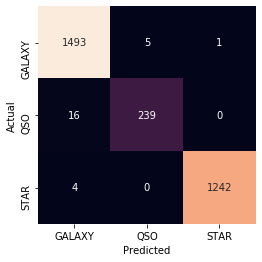

In [76]:
acc = round(accuracy_score(y_test, y_pred_bayesian),3)
rec = round(recall_score(y_test, y_pred_bayesian, average="macro"), 3)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
met = confusion_matrix(y_test, y_pred_bayesian)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False, xticklabels=['GALAXY', 'QSO', 'STAR'], yticklabels=['GALAXY', 'QSO', 'STAR'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

 - __Useful links__

https://github.com/fmfn/BayesianOptimization

https://aiinpractice.com/xgboost-hyperparameter-tuning-with-bayesian-optimization/
    
https://analyticsindiamag.com/implementing-bayesian-optimization-on-xgboost-a-beginners-guide/